# Final Project: Hugging Face (Testing the Model)

This code uses : [https://huggingface.co/docs/datasets/en/quickstart#vision]

I am using python version: 3.12.4
           numpy version: 1.26.4
           scipy version: 1.13.1
           evaluate version: 0.4.3
           matplotlib version: 3.9.2

If you do not have these, please uncomment the cell below.

In [ ]:
# If you do not have the right versions, you can uncomment the lines below:
# python3.12 -m venv myenv
# source myenv/bin/activate  # On Windows: myenv\Scripts\activate
# pip install --upgrade pip
# pip install numpy==1.26.4 scipy==1.13.1 evaluate==0.4.3 matplotlib==3.9.2

In [ ]:
#### If you skipped the generating model PLEASE DO THIS ####

### MAKE SURE YOU HAVE ALL OF THIS INSTALLED BEFORE RUNNING THE CODE ###

# Pip intalling necessary items
! pip install datasets
! pip install datasets[vision] #used to work with the Image features 

# I will be using Pytorch for this project, so I will install it here. But you can use Tensorflow if you prefer
! pip install torch
! pip install torchvision


# I will be using the Hugging Face Transformers library for this project
! pip install transformers[torch]
! pip install "accelerate>=0.26.0"
! pip install transformers
! pip install evaluate
! pip install Pillow

! pip install keras
! pip install tensorflow
! pip install astroNN
! pip install --upgrade tensorflow tensorflow-probability
! pip install tensorflow-probability\[tf\]


In [1]:
import numpy as np 
import evaluate
import torch
import matplotlib.pyplot as plt

from datasets import load_dataset, Image
from transformers import AutoImageProcessor
from torchvision.transforms import Compose, ColorJitter, ToTensor,  RandomResizedCrop, Normalize
from transformers import DefaultDataCollator
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor
from transformers import pipeline # Use a pipeline as a high-level helper
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Checking Validity of Model

In [2]:
pipe = pipeline("image-classification", model="brigettesegovia/plant_classification") # vit-base-beans

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [3]:
# Load model directly from hugging face
image_processor = AutoImageProcessor.from_pretrained("brigettesegovia/plant_classification")
model = AutoModelForImageClassification.from_pretrained("brigettesegovia/plant_classification")

In [4]:
# Loading dataset
# Every image that is loaded must be in jpg format. 
# The image must be in a folder with the same name as the label.
# An example is angular_leafspot/angular_leafspot_0.jpg, angular_leafspot/angular_leafspot_1.jpg, etc.
def visualize_leafs(folder_name, num_images=5):
    ''' folder_name: a string with the name of the folder that contains the images you want to test
        num_images: an integer with the number of images you want to test
        returns: a list of PIL images
    '''
    images = [] 
    for i in range(0, num_images):
        try:
            image_path = f"{folder_name}/{folder_name}_{i}.jpg"
            images.append(Image.open(image_path))
        except:
            raise TypeError(f"Image {i} not found. Check that num_images matches the number of images in your folder and that the images are of the format 'jpg'. ")
    return images

# I have three folder each containing 6 images. I will visualize the images in each folder.
images_angular_leafspot = visualize_leafs("angular_leafspot")
images_healthy = visualize_leafs("healthy")
images_bean_rust = visualize_leafs("bean_rust")

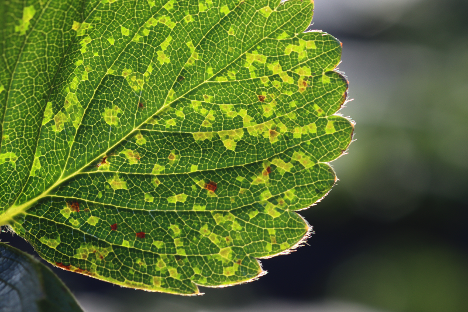

In [5]:
# Quickly check that the images where generated as expected 
images_angular_leafspot[0]

In [6]:
# prepare image for the model
# The model expects the images to be in the format of a tensor.
def prepare_image(image_list):
    encoding = []
    for image in image_list:
        encoding.append(image_processor(image.convert("RGB"), return_tensors="pt"))
    return encoding

encoding_angular_leafspot = prepare_image(images_angular_leafspot)
encoding_healthy = prepare_image(images_healthy)
encoding_bean_rust = prepare_image(images_bean_rust)

print(encoding_bean_rust[0].pixel_values.shape) # checking for the expected output (should be torch.Size([1, 3, 224, 224]) as per Swin) 

torch.Size([1, 3, 224, 224])


In [7]:
# # Now we get the final predictions that the model outputs for each image.
# # The model outputs logits, which are the raw, unnormalized scores that the model generates for each class.
def predictions(encoding_list):
    return [model.config.id2label[logits.argmax(-1).item()] for encoding in encoding_list for logits in [model(**encoding).logits]]

predictions_angular_leafspot = predictions(encoding_angular_leafspot)
predictions_healthy = predictions(encoding_healthy)
predictions_bean_rust = predictions(encoding_bean_rust)

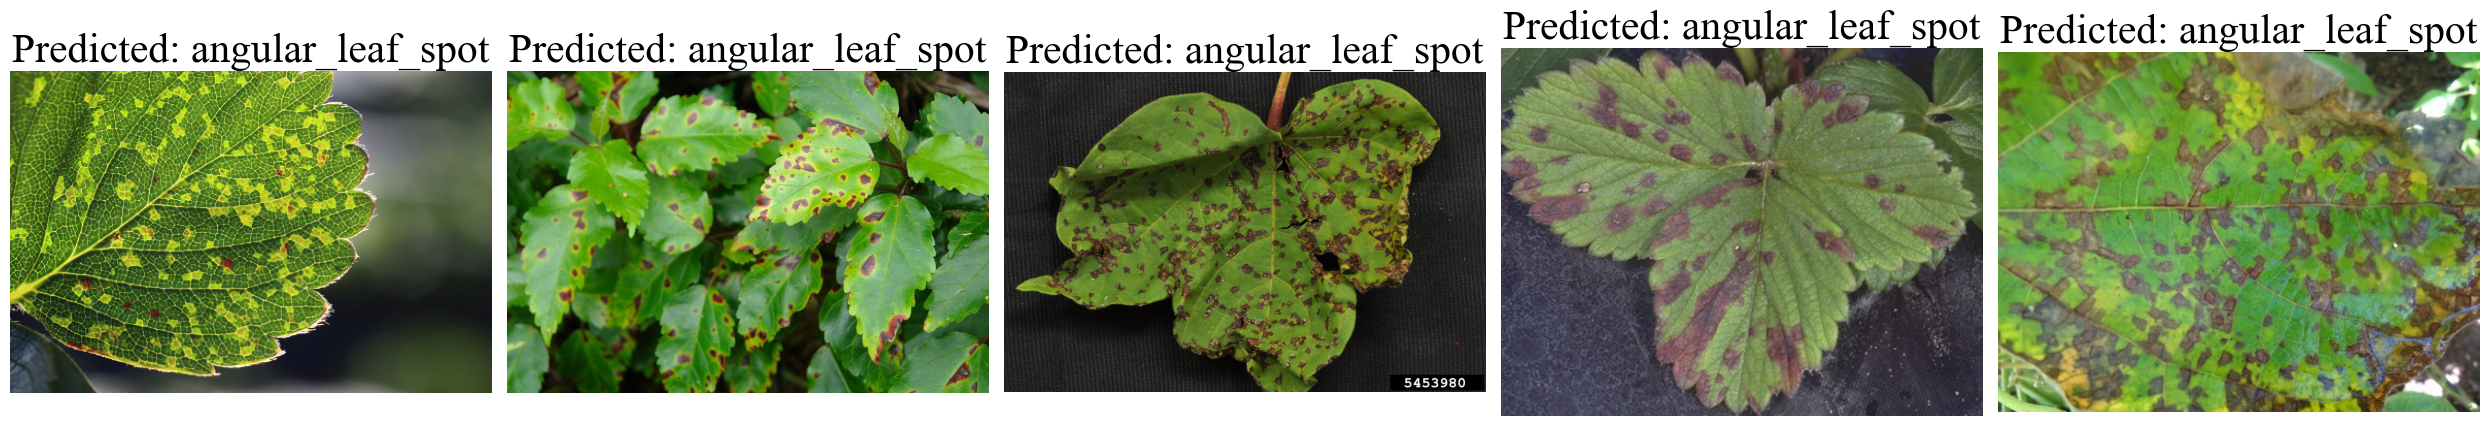

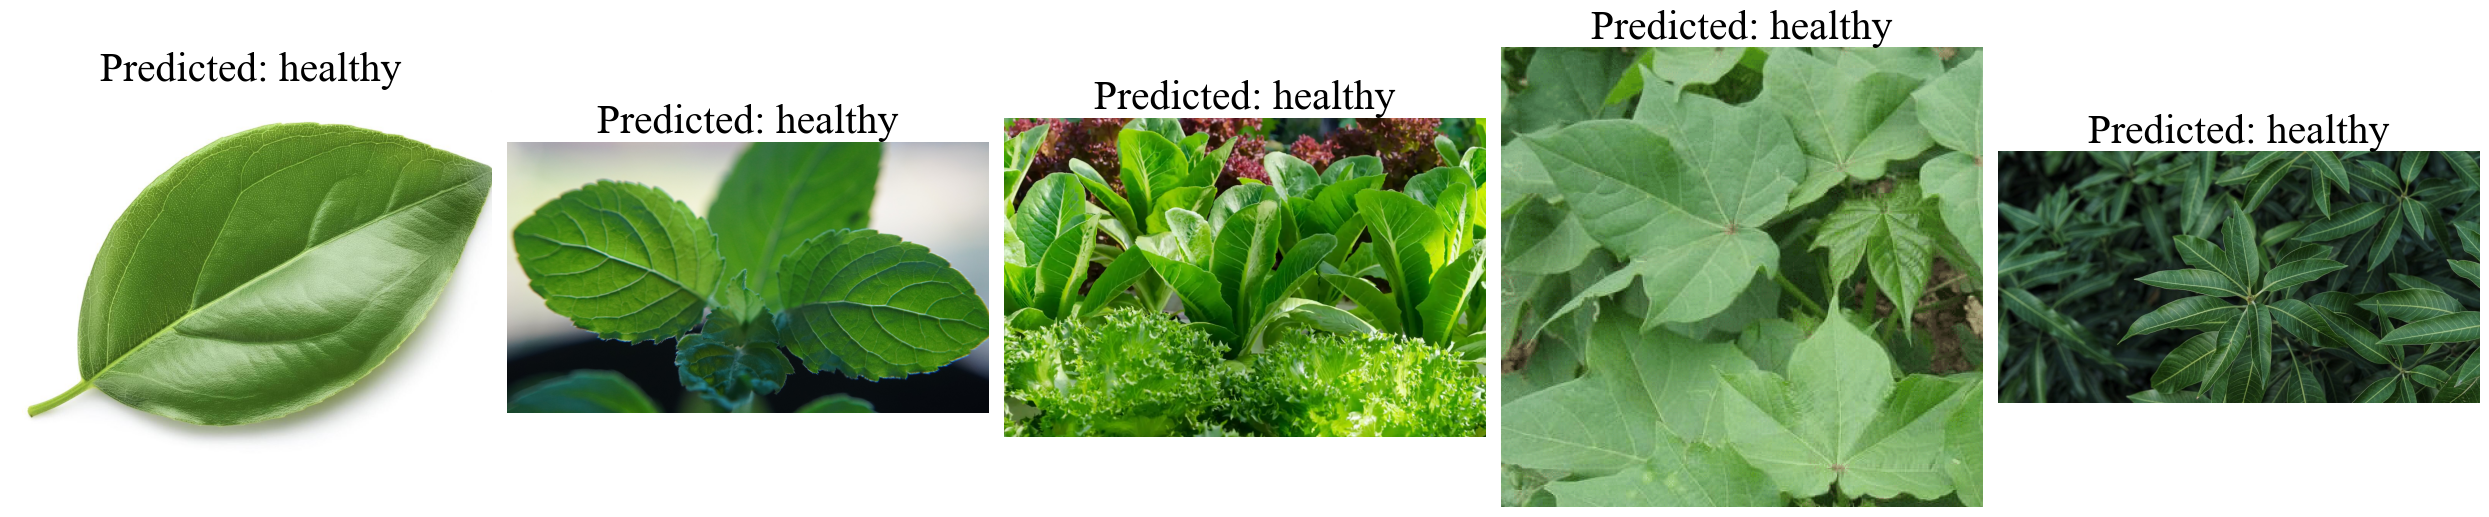

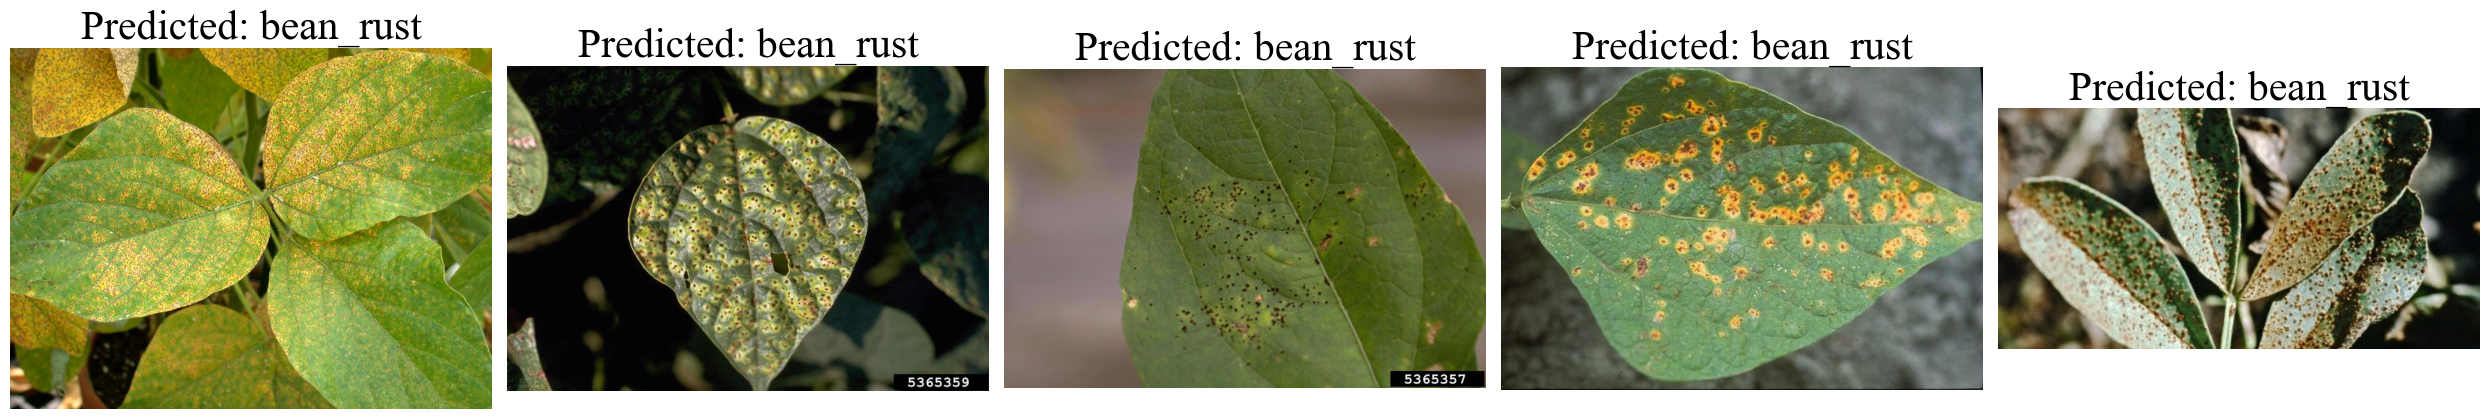

In [8]:
# This function will nicely display your images with their predicted classifications
def display_images_with_predictions(images, predictions, image_size=(5, 5)):
    fig, axes = plt.subplots(1, len(images), figsize=(image_size[0] * (len(images)), image_size[-1]*1.2))
    for img, pred, ax in zip(images, predictions, axes):
        ax.imshow(img)
        ax.set_title(f"Predicted: {pred}", font='Times New Roman', fontsize=30)
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"final_project_im/predictions{"".join(pred.split())}.png", dpi=250)
    plt.show()

# Display images with their predictions
display_images_with_predictions(images_angular_leafspot, predictions_angular_leafspot)
display_images_with_predictions(images_healthy, predictions_healthy)
display_images_with_predictions(images_bean_rust, predictions_bean_rust)

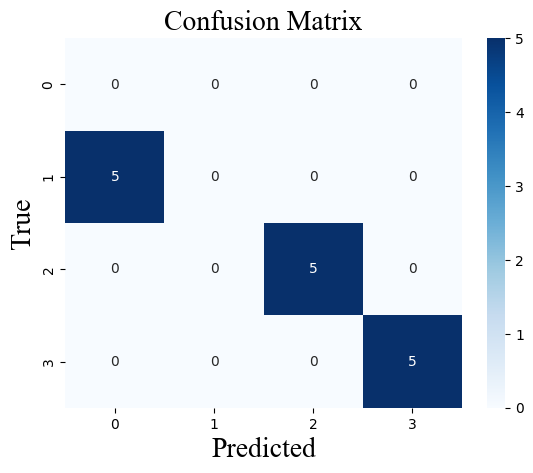

In [9]:
# We can look at the confusion matrix
# This can show us how well the model is doing at classifying the images
cm = confusion_matrix(['angular_leafspot']*5 + ['healthy']*5 + ['bean_rust']*5, predictions_angular_leafspot + predictions_healthy + predictions_bean_rust)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted',  font='Times New Roman', fontsize=20)
plt.ylabel('True', font='Times New Roman', fontsize=20)
plt.title('Confusion Matrix',  font='Times New Roman', fontsize=20)
plt.savefig("final_project_im/confusion_matrix.png", dpi=250)
plt.show()
